qiskit                    2.2.3                    pypi_0    pypi
qiskit-aer                0.17.2                   pypi_0    pypi
qiskit-algorithms         0.4.0                    pypi_0    pypi
qiskit-ibm-runtime        0.40.0                   pypi_0    pypi
qiskit-machine-learning   0.7.0                    pypi_0    pypi

In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator
from qiskit.circuit.library import ZZFeatureMap
from qiskit.providers.jobstatus import JOB_FINAL_STATES
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import time

In [2]:
# ==== データ読み込み ====
df = pd.read_excel("Dataset_Simulated_Price_swaption.xlsx")
col_name = "Tenor : 1; Maturity : 0.0833333333333333"
data = df[col_name].dropna().values

# # ==== 特徴量作成 ====
window = 5
X, y = [], []
for i in range(len(data) - window):
    X.append(data[i:i+window])
    y.append(data[i+window])
X, y = np.array(X), np.array(y)

# ==== データ数を制限 ====
N_samples = 50  # 使用するサンプル数
X, y = X[-N_samples:], y[-N_samples:]

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# ==== 訓練・テスト分割 ====
# split = int(len(X) * 0.8)
# X_train, X_test = X[:split], X[split:]
# y_train, y_test = y[:split], y[split:]
split = int(len(X_scaled)*0.8)
X_train, X_test = X_scaled[:split], X_scaled[split:]
y_train, y_test = y_scaled[:split], y_scaled[split:]

In [11]:
# ==== 量子特徴マップ ====
num_qubits = X_train.shape[1]
feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=2, entanglement="linear")
sim_backend = AerSimulator(method="statevector")  # ローカルの statevector シミュレータ
service = QiskitRuntimeService()
# service.backends()
# backend = service.backend('ibm_fez') 
backend = service.backend('ibm_marrakesh') 


/var/folders/4t/f9s2s80n15d24fg2pl23l77c0000gn/T/ipykernel_94104/3639563496.py:3: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._zz_feature_map.ZZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the zz_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=2, entanglement="linear")


In [5]:
def create_feature_circuit(feature_map, x):
    """パラメータを割り当てた回路を返す（transpile は実行時に行う）"""
    qc = feature_map.assign_parameters({p: v for p, v in zip(feature_map.parameters, x)})
    qc = qc.decompose(reps=3)
    return qc


def quantum_kernel_matrix_measurement(feature_map, X1, X2, backend, shots=1024, batch_size=10):
    """実機で K[i,j] = |<phi(X1[i])|phi(X2[j])>|^2 を測定ベースで推定"""
    n1, n2 = len(X1), len(X2)
    kernel = np.zeros((n1, n2))
    circuits = []
    index_map = []

    # すべてのペア (X1[i], X2[j]) に対して回路を構築
    for i in range(n1):
        qc_i = create_feature_circuit(feature_map, X1[i]).inverse()
        for j in range(n2):
            qc_j = create_feature_circuit(feature_map, X2[j])
            qc = QuantumCircuit(num_qubits)
            qc.compose(qc_i, inplace=True)
            qc.compose(qc_j, inplace=True)
            qc.measure_all()
            circuits.append(qc)
            index_map.append((i, j))

    # バッチごとに実行
    for start in range(0, len(circuits), batch_size):
        batch = circuits[start:start + batch_size]
        batch_map = index_map[start:start + batch_size]

        transpiled = transpile(batch, backend=backend, optimization_level=3)
        job = backend.run(transpiled, shots=shots)

        print(f"Submitted job {job.job_id()} with {len(batch)} circuits. Waiting...")
        while job.status() not in JOB_FINAL_STATES:
            time.sleep(5)

        result = job.result()

        # 各回路の測定結果からカーネル値を計算
        for idx in range(len(transpiled)):
            counts = result.get_counts(idx)
            zeros = '0' * num_qubits
            count_zeros = counts.get(zeros, 0)
            prob_zero = count_zeros / shots
            i, j = batch_map[idx]
            kernel[i, j] = prob_zero

    return kernel


def quantum_kernel_matrix(feature_map, X1, X2, backend=None, shots=1024, batch_size=10):
    """バックエンドがシミュレータならstatevectorで正確に計算、実機なら測定ベースで推定"""
    if backend is None:
        backend = sim_backend

    # ==========================
    # シミュレーターの場合
    # ==========================
    if getattr(backend.configuration(), 'simulator', False):
        n1, n2 = len(X1), len(X2)
        kernel = np.zeros((n1, n2))

        # φ(X1) と φ(X2) の状態ベクトルを取得してキャッシュ
        state_cache1, state_cache2 = [], []

        for x in X1:
            qc = create_feature_circuit(feature_map, x)
            qc.save_statevector()
            t = transpile(qc, backend=backend)
            res = backend.run(t).result()
            state = res.get_statevector(0)
            state_cache1.append(state)

        for x in X2:
            qc = create_feature_circuit(feature_map, x)
            qc.save_statevector()
            t = transpile(qc, backend=backend)
            res = backend.run(t).result()
            state = res.get_statevector(0)
            state_cache2.append(state)

        # 内積からカーネル値を計算
        for i, si in enumerate(state_cache1):
            for j, sj in enumerate(state_cache2):
                kernel[i, j] = np.abs(np.vdot(si, sj)) ** 2

        return kernel

    # ==========================
    # 実機またはショットベースのバックエンドの場合
    # ==========================
    else:
        print("Note: using measurement-based kernel estimation on real backend.")
        return quantum_kernel_matrix_measurement(
            feature_map, X1, X2, backend, shots=shots, batch_size=batch_size
        )


In [12]:
K_train = quantum_kernel_matrix(feature_map, X_train, X_train, backend=sim_backend)
K_test  = quantum_kernel_matrix(feature_map, X_test,  X_train, backend=sim_backend)

In [13]:
# ==== 回帰 ====
model = KernelRidge(alpha=1.0, kernel="precomputed")
model.fit(K_train, y_train)
y_pred = model.predict(K_test)

In [14]:
# ==== 逆スケーリング & 評価 ====
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_inv = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
# y_test_inv = y_test
# y_pred_inv = y_pred
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f"RMSE: {rmse:.6f}")

RMSE: 0.004804


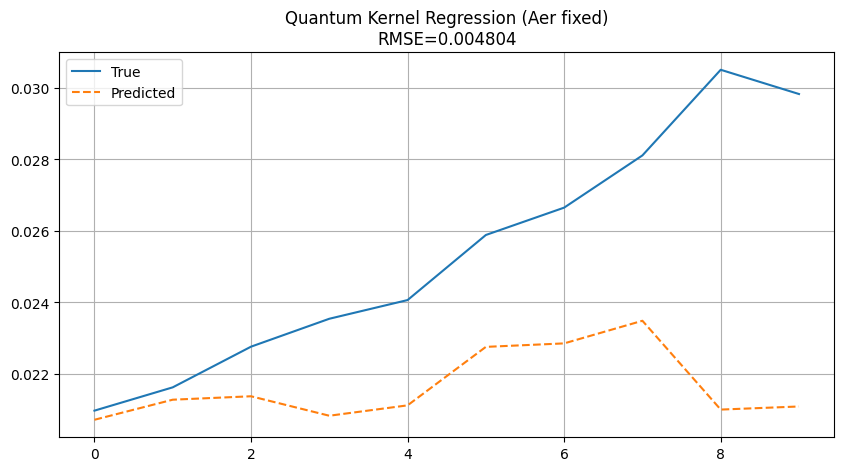

In [15]:
plt.figure(figsize=(10,5))
plt.plot(y_test_inv, label="True")
plt.plot(y_pred_inv, label="Predicted", linestyle="--")
plt.legend()
plt.title(f"Quantum Kernel Regression (Aer fixed)\nRMSE={rmse:.6f}")
plt.grid(True)
plt.show()


In [22]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

# === 1. データ読み込み ===
df = pd.read_csv("Dataset_Simulated_Price_swaption.csv")
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.set_index('Date').sort_index()

# === 2. 列名から tenor / maturity を抽出 ===
import re
tenor_maturity = []
for col in df.columns:
    m = re.search(r'Tenor\s*:\s*(\d+).*?Maturity\s*:\s*([\d.]+)', col)
    if m:
        tenor = float(m.group(1))
        maturity = float(m.group(2))
        tenor_maturity.append((col, tenor, maturity))
    else:
        # データ形式が "Tenor1_Maturity0.0833" のような場合はこちら
        m = re.search(r'Tenor(\d+)_Maturity([\d.]+)', col)
        if m:
            tenor = float(m.group(1))
            maturity = float(m.group(2))
            tenor_maturity.append((col, tenor, maturity))

# === 3. 時系列特徴量を作成 ===
lags = 5
rows = []

for col, tenor, maturity in tenor_maturity:
    series = pd.to_numeric(df[col], errors='coerce').dropna()
    data = pd.DataFrame({'y': series})
    for i in range(1, lags + 1):
        data[f'lag_{i}'] = series.shift(i)
    data['tenor'] = tenor
    data['maturity'] = maturity
    data = data.dropna()
    rows.append(data)

# 全系列を結合
all_data = pd.concat(rows)

In [23]:
# # === 4. 訓練データとテストデータ ===
# split_idx = int(len(all_data) * 0.8)
# train = all_data.iloc[:split_idx]
# test = all_data.iloc[split_idx:]

# X_train = train.drop('y', axis=1)
# y_train = train['y']
# X_test = test.drop('y', axis=1)
# y_test = test['y']

# === 4. 訓練データとテストデータ（日付インデックス基準） ===
# 日付でソート
all_data = all_data.sort_index()

# 8割の位置の日付を取得
split_date = all_data.index[int(len(all_data) * 0.8)]

# 日付を基準にデータを分割
train = all_data[all_data.index <= split_date]
test = all_data[all_data.index > split_date]

# 特徴量と目的変数を分割
X_train = train.drop('y', axis=1)
y_train = train['y']
X_test = test.drop('y', axis=1)
X_test_tnr_1_0_mtr_0_0833 = X_test[
    (X_test["tenor"] == 1.0) &
    (X_test["maturity"].sub(0.0833333333333333).abs() < 1e-6)
]
y_test = test['y']
y_test_tnr_1_0_mtr_0_0833 = y_test[
    (X_test["tenor"] == 1.0) &
    (X_test["maturity"].sub(0.0833333333333333).abs() < 1e-6)
]

print(f"📆 Split date: {split_date}")
print(f"✅ Train size: {len(train)}, Test size: {len(test)}")

📆 Split date: 2051-08-10 00:00:00
✅ Train size: 88928, Test size: 21952


In [28]:
# import numpy as np
# import pandas as pd
# from qiskit import QuantumCircuit, Aer, transpile
# from qiskit.circuit.library import ZZFeatureMap
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# ----------------------------
# ① データ準備
# ----------------------------
# DataFrame → NumPy 配列へ
X_train_np = X_train.values
X_test_np = X_test.values
y_train_np = y_train.values
y_test_np = y_test.values

# スケーリング（量子特徴マップは -π～π の入力が適している）
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_np)
X_test_scaled = scaler.transform(X_test_np)

# ----------------------------
# ② 量子特徴マップを定義
# ----------------------------
num_qubits = X_train_scaled.shape[1]
feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=2)

# sim_backend = Aer.get_backend('aer_simulator_statevector')
sim_backend = service.backend('ibm_marrakesh') 

/var/folders/4t/f9s2s80n15d24fg2pl23l77c0000gn/T/ipykernel_94104/1522826864.py:27: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._zz_feature_map.ZZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the zz_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=2)


In [30]:
# ----------------------------
# ③ 量子カーネル行列を作成
# ----------------------------
K_train = quantum_kernel_matrix(feature_map, X_train_scaled, X_train_scaled, backend=sim_backend, shots=4)

Note: using measurement-based kernel estimation on real backend.


KeyboardInterrupt: 

In [ ]:
K_test = quantum_kernel_matrix(feature_map, X_test_scaled, X_train_scaled, backend=sim_backend)

In [ ]:
# ----------------------------
# ④ カーネルリッジ回帰を実行
# ----------------------------
krr = KernelRidge(alpha=1e-3, kernel='precomputed')
krr.fit(K_train, y_train_np)

# 予測
y_pred = krr.predict(K_test)

# ----------------------------
# ⑤ 性能評価
# ----------------------------
rmse = np.sqrt(mean_squared_error(y_test_np, y_pred))
print(f"RMSE: {rmse:.4f}")

In [ ]:
# ==== 量子特徴マップ ====
num_qubits = X_train.shape[1]
feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=2, entanglement="linear")
# sim_backend = AerSimulator(method="statevector")  # ローカルの statevector シミュレータ
sim_backend = service.backend('ib_fez')

/var/folders/4t/f9s2s80n15d24fg2pl23l77c0000gn/T/ipykernel_94104/346618486.py:3: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._zz_feature_map.ZZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the zz_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=2, entanglement="linear")


In [6]:
K_train = quantum_kernel_matrix(feature_map, X_train, X_train, backend=sim_backend)
K_test  = quantum_kernel_matrix(feature_map, X_test,  X_train, backend=sim_backend)

TypeError: Cannot assign object (l) object to parameter.

In [ ]:
# ==== 回帰 ====
model = KernelRidge(alpha=1.0, kernel="precomputed")
model.fit(K_train, y_train)
y_pred = model.predict(K_test)

In [ ]:
# ==== 逆スケーリング & 評価 ====
# y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
# y_pred_inv = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
# y_test_inv = y_test
# y_pred_inv = y_pred
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# print(f"RMSE: {rmse:.6f}")

y_pred = model.predict(X_test)
y_pred_tnr_1_0_mtr_0_0833 = model.predict(X_test_tnr_1_0_mtr_0_0833)
# === 6. 評価 ===
mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse:.6f}")

mse_tnr_1_0_mtr_0_0833 = mean_squared_error(y_test_tnr_1_0_mtr_0_0833, y_pred_tnr_1_0_mtr_0_0833)
print(f"MSE (tenor=1.0, maturity=0.0833): {mse_tnr_1_0_mtr_0_0833:.6f}")

In [ ]:
# 作図
# plt.figure(figsize=(10,4))
# plt.plot(y_test.index, y_test.values, label='actual')
# plt.plot(y_test.index, preds, label='predicted')
# plt.title(f'Actual vs Predicted — {target_col}')
# plt.legend()
# plt.tight_layout()
# plt.show()
plt.figure(figsize=(10,4))
plt.plot(y_test_tnr_1_0_mtr_0_0833.index, y_test_tnr_1_0_mtr_0_0833.values, label='actual')
plt.plot(y_test_tnr_1_0_mtr_0_0833.index, y_pred_tnr_1_0_mtr_0_0833, label='predicted')
plt.title(f'Actual vs Predicted — tenor=1.0, maturity=0.0833')
plt.legend()
plt.tight_layout()
plt.show()
